In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Mounted at /content/drive


In [2]:
# modelo
m = 2
# tamanho da janela deslizante
n = 3
# ataque
at = 1
veremiPath = "/content/drive/MyDrive/dataset/veremi"
t2Path = "/veremiWithT2"
simcsvPath = '/simulationscsv'
window = "/window"+str(n)+"v2"
model = "/model"+str(m)
preprocessing = "/preprocessing"
atk = "/atk"+str(at)

os.chdir(veremiPath+t2Path+window+model+atk)
os.listdir()

['variables',
 'assets',
 'keras_metadata.pb',
 'saved_model.pb',
 'PRcurve md2w3at1.pdf',
 'md2w3at1.pdf',
 'ROCcurve md2w3at1.pdf']

In [3]:
# transformar os demais ataques em label 0
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
os.chdir(veremiPath+t2Path+window+model+'/allscenarios2')
allsc2 = pd.read_csv('allsc2.csv', index_col=0)
allsc2.iloc[:, -1].loc[allsc2.iloc[:, -1] != at] = 0
# allsc2.iloc[:, -1].unique()
# split data and label
data = allsc2.iloc[:, 0:-1].values
classes = allsc2.iloc[:, -1].values
# multilabel binarize
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.classes_
classes = lb.transform(classes)
classes = MultiLabelBinarizer().fit_transform(classes)
# split test and train
data_train, data_test, classes_train, classes_test = train_test_split(data, classes, test_size=0.2, random_state=1)
print('data_train', data_train.shape)
print('data_test', data_test.shape)
print('classes_train', classes_train.shape)
print('classes_test', classes_test.shape)
clTrain = lb.inverse_transform(classes_train)
clTest = lb.inverse_transform(classes_test)
# classes_train
clTrain = pd.Series(clTrain)
qtd0 = len(clTrain.loc[clTrain == 0])
qtdat = len(clTrain.loc[clTrain == at])
print('classes_train binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtdat), '%')
print('qtd '+str(at)+' = ', qtdat, '|', qtdat*100/(qtd0+qtdat), '%')
# classes_test
clTest = pd.Series(clTest)
qtd0 = len(clTest.loc[clTest == 0])
qtdat = len(clTest.loc[clTest == at])
print('classes_test binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtdat), '%')
print('qtd '+str(at)+' = ', qtdat, '|', qtdat*100/(qtd0+qtdat), '%')

data_train (14817733, 2)
data_test (3704434, 2)
classes_train (14817733, 2)
classes_test (3704434, 2)
classes_train binary distribution:
qtd 0 =  14239836 | 96.0999634694457 %
qtd 1 =  577897 | 3.9000365305543028 %
classes_test binary distribution:
qtd 0 =  3559982 | 96.10056489061486 %
qtd 1 =  144452 | 3.8994351093851316 %


In [4]:
# modelo rede neural
layer1 = keras.Input(shape=(data_train.shape[1],))
layer2 = keras.layers.Dense(7, activation="relu")(layer1)
layer3 = keras.layers.Dense(7, activation="relu")(layer2)
output = keras.layers.Dense(2, activation="softmax")(layer3)
modelrelu = keras.Model(inputs=layer1, outputs=output, name='model'+str(m)+'relu')
print(modelrelu.summary())
# keras.utils.plot_model(model, "my_model.png", show_shapes=True)
modelrelu.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.Recall(class_id=1)],
)
start_time = time.time()
early_stopping = EarlyStopping(
    monitor="loss",
    patience=3,
    min_delta=1e-4,
    restore_best_weights=True
)
modelrelu.fit(
    data_train,
    classes_train,
    epochs=200,
    batch_size=1000,
    callbacks=[early_stopping]
)
print('Done in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='')
modelrelu.save(veremiPath+t2Path+window+model+atk)

Model: "model2relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 7)                 21        
                                                                 
 dense_1 (Dense)             (None, 7)                 56        
                                                                 
 dense_2 (Dense)             (None, 2)                 16        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
14818/14818 [==============================] - 45s 3ms/step - loss: 0.1383 - binary_accuracy: 0.9610 - recall: 4.4991e-05
Epoch 2/200
14818/14818 [============================

Best Threshold=0.053342, F-Score=0.412
----------------------------------------------------------------------
Classification Report for md2w3at1
              precision    recall  f1-score   support

   class all      0.980     0.960     0.970   3559982
     class 1      0.344     0.513     0.412    144452

    accuracy                          0.943   3704434
   macro avg      0.662     0.737     0.691   3704434
weighted avg      0.955     0.943     0.948   3704434

----------------------------------------------------------------------


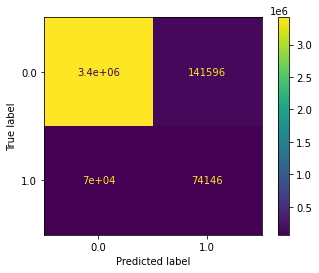

----------------------------------------------------------------------


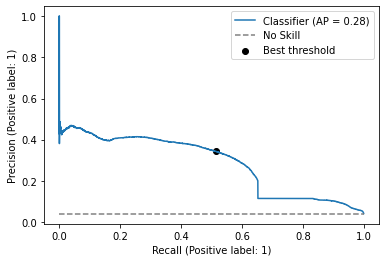

----------------------------------------------------------------------


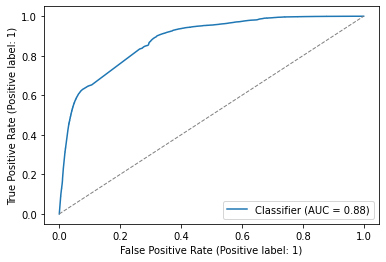

In [5]:
# metrics
modelrelu = keras.models.load_model(veremiPath+t2Path+window+model+atk)
predictsrelu = modelrelu.predict(data_test)
clTest = lb.inverse_transform(classes_test)
os.chdir(veremiPath+t2Path+window+model+atk)
# Best threshold
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(clTest, predictsrelu[:, 1], pos_label=at)
# convert to f score
np.seterr(divide='ignore', invalid='ignore')
fscore = (2 * precision * recall) / (precision + recall)
np.nan_to_num(fscore, copy=False)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print("-"*70)
# Classification Report
from sklearn.metrics import classification_report
# predictsrelu = modelrelu.predict(data_test)
# clTest = lb.inverse_transform(classes_test)
predrelu = lb.inverse_transform(predictsrelu, threshold=thresholds[ix])
print('Classification Report for md'+str(m)+'w'+str(n)+'at'+str(at))
print(classification_report(clTest, predrelu, target_names=['class all', 'class '+str(at)], digits=3))
print("-"*70)
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# predrelu = lb.inverse_transform(predictsrelu, threshold=thresholds[ix])
cm = confusion_matrix(clTest, predrelu, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)
disp.plot()
# plt.title('md'+str(m)+'w'+str(n)+'at'+str(at)+'.pdf')
plt.savefig('md'+str(m)+'w'+str(n)+'at'+str(at)+'.pdf')
plt.show()
print("-"*70)
# Precision-Recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(clTest, predictsrelu[:, 1], pos_label=at)
# plt.title('PR curve '+'md'+str(m)+'w'+str(n)+'at'+str(at)+'.pdf')
no_skill = len(clTest[clTest==1]) / len(clTest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', color="grey", label='No Skill')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best threshold')
plt.legend()
plt.savefig('PRcurve '+'md'+str(m)+'w'+str(n)+'at'+str(at)+'.pdf')
plt.show()
print("-"*70)
# ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(clTest, predictsrelu[:, 1], pos_label=at)
# plt.title('ROC curve '+'md'+str(m)+'w'+str(n)+'at'+str(at)+'.pdf')
plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.savefig('ROCcurve '+'md'+str(m)+'w'+str(n)+'at'+str(at)+'.pdf')
plt.show()